# 개요

time-series => spectrogram (image 형태) => CNN의 경우 spectorgram의 시간적인 정보가 사라지므로 손해 발생

(multivariate) time-series의 Recurrent plot을 input으로 넣어보자

reference: https://www.kaggle.com/code/tigurius/recuplots-and-cnns-for-time-series-classification

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.spatial.distance import pdist, squareform #scipy spatial distance
import sklearn as sk
import sklearn.metrics.pairwise
import matplotlib.pyplot as plt
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, LeakyReLU
from keras import metrics
from keras import backend as K
import time
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils

In [30]:
#modified from https://stackoverflow.com/questions/33650371/recurrence-plot-in-python
def recurrence_plot(s, eps=None, steps=None):
    if eps == None: eps=0.1
    if steps == None: steps=10
    # default = euclidean distance
    # d[i, j] == np.sqrt(np.sum((s[i] - s[j]) ** 2))
    d = sk.metrics.pairwise.pairwise_distances(s)
    d = np.floor(d / eps)  # 0.6xx, 0.7xx, ... 등의 실수값을 6.xx, 7.xx 등으로 바꾸고 6, 7 의 정수만 남김
    d[d > steps] = steps  # 자신간의 distance가 threshold를 넘는 것들을 남긴다.
    #Z = squareform(d)
    return d

[0.63887766 0.02683229 0.96772876 0.18593764 0.47826033 0.40772707
 0.63499574 0.49493363 0.62302505 0.13043076]
[[0. 6. 3. ... 1. 2. 2.]
 [6. 0. 9. ... 8. 8. 8.]
 [3. 9. 0. ... 1. 0. 0.]
 ...
 [1. 8. 1. ... 0. 0. 0.]
 [2. 8. 0. ... 0. 0. 0.]
 [2. 8. 0. ... 0. 0. 0.]]


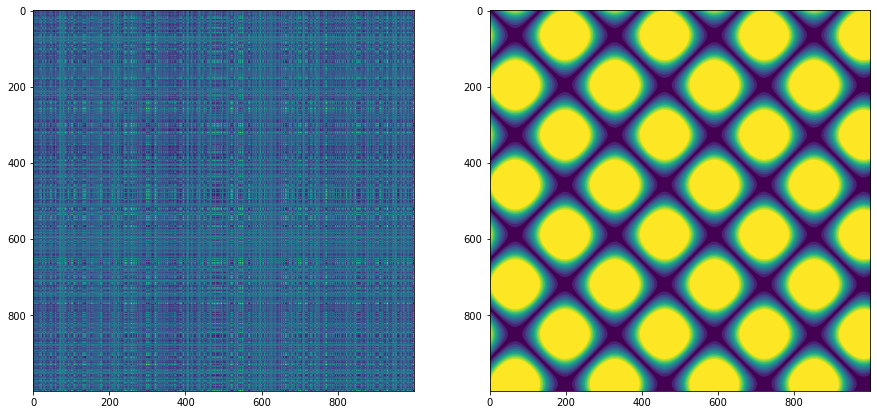

In [8]:
fig = plt.figure(figsize=(15,14))
random_series = np.random.random(1000)
ax = fig.add_subplot(1, 2, 1)
recur_plot = recurrence_plot(random_series[:, None])  # pattern 없이 랜덤한 경우 별 의미없는 그림이 나오고
ax.imshow(recur_plot)
sinus_series = np.sin(np.linspace(0,24,1000))  # sine 처럼 패턴이 있는 경우 기하학적인 그림이 나온다.
ax = fig.add_subplot(1, 2, 2)
ax.imshow(recurrence_plot(sinus_series[:,None]));

In [12]:
# MotionSense 데이터 시각화
def plot_motion_data(idx: int):
    cols = ["attitude.roll","attitude.pitch","attitude.yaw","gravity.x","gravity.y","gravity.z","rotationRate.x","rotationRate.y","rotationRate.z","userAcceleration.x", "userAcceleration.y", "userAcceleration.z"]
    path = "./data/MotionSense/A_DeviceMotion_data"
    fig = plt.figure(figsize=(15,14))
    ax = fig.add_subplot(2, 3, 1)
    ax.imshow(recurrence_plot(pd.read_csv(f"{path}/wlk_15/sub_{idx}.csv")[cols].values,steps=1000))
    ax.set_xlabel('Walking')
    ax = fig.add_subplot(2, 3, 2)
    ax.imshow(recurrence_plot(pd.read_csv(f"{path}/sit_5/sub_{idx}.csv")[cols].values,steps=1000))
    ax.set_xlabel('Sitting')
    ax = fig.add_subplot(2, 3, 3)
    ax.imshow(recurrence_plot(pd.read_csv(f"{path}/jog_9/sub_{idx}.csv")[cols].values,steps=1000))
    ax.set_xlabel('Jogging')
    ax = fig.add_subplot(2, 3, 4)
    ax.imshow(recurrence_plot(pd.read_csv(f"{path}/dws_1/sub_{idx}.csv")[cols].values,steps=1000))
    ax.set_xlabel('Downstairs')
    ax = fig.add_subplot(2, 3, 5)
    ax.imshow(recurrence_plot(pd.read_csv(f"{path}/std_6/sub_{idx}.csv")[cols].values,steps=1000))
    ax.set_xlabel('Standing')
    ax = fig.add_subplot(2, 3, 6)
    ax.imshow(recurrence_plot(pd.read_csv(f"{path}/ups_3/sub_{idx}.csv")[cols].values,steps=1000))
    ax.set_xlabel('Upstairs')

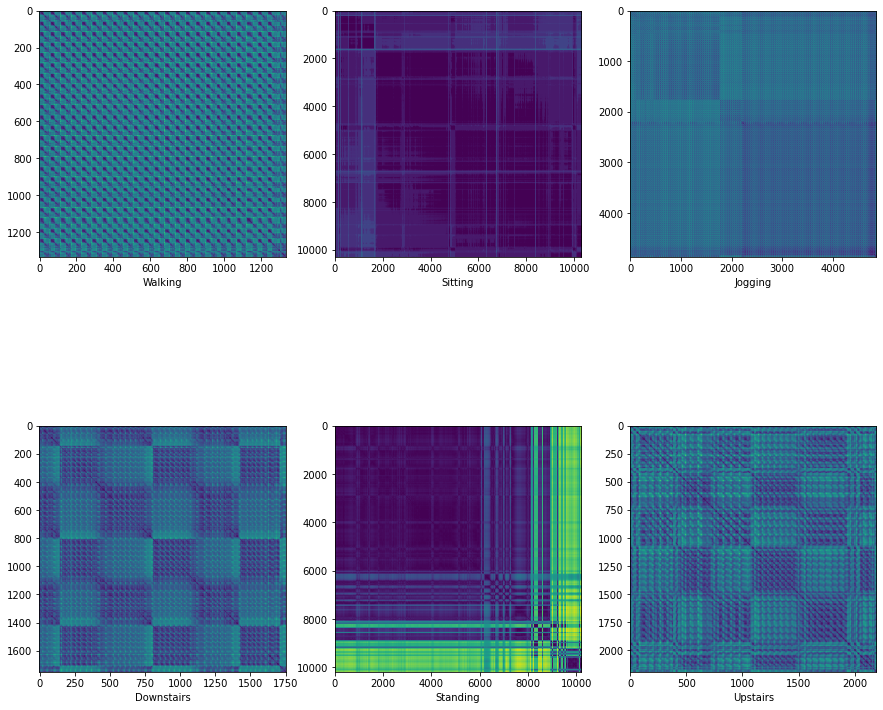

In [31]:
plot_motion_data(1)

In [33]:
# convert folders to class labels
# downstairs/upstairs = 0,walking/jogging  = 1, standing/sitting = 2
class_translate = {"dws_1" : 0, "dws_2" : 0, "dws_11" : 0,
                   "ups_3" : 0, "ups_4" : 0, "ups_12" : 0,
                   "wlk_7" : 1, "wlk_8" : 1, "wlk_15" : 1,
                   "jog_9" : 1, "jog_16" : 1,
                   "std_6" : 2, "std_14" : 2,
                   "sit_5" : 2, "sit_13": 2}

path = "./data/MotionSense/A_DeviceMotion_data"

#pre allocate arrays
x_train = np.zeros((384,32,32))
y_train = np.zeros(384)
c = 0
start = time.time()
for i in class_translate.keys():
    print("Processing set " + i)
    for j in range(1,25):
        dat = recurrence_plot(pd.read_csv(path + "/" + i +"/" + "sub_"+ str(j) + ".csv")[cols].values, steps=100)
        dat = resize(dat, (32,32),mode='constant')
        x_train[c,:,:] = dat
        y_train[c] = class_translate[i]
        c = c + 1
end = time.time()
print('Elapsed time:')
print(end - start)

Processing set dws_1
Processing set dws_2
Processing set dws_11
Processing set ups_3
Processing set ups_4
Processing set ups_12
Processing set wlk_7
Processing set wlk_8
Processing set wlk_15
Processing set jog_9
Processing set jog_16
Processing set std_6
Processing set std_14
Processing set sit_5
Processing set sit_13
Elapsed time:
8924.063253641129


In [ ]:
model = Sequential()

model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(1,32,32), data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Convolution2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(LeakyReLU(alpha=0.03))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
#reshape to include depth
X_train = x_train.reshape(x_train.shape[0], 1, 32,32)
#convert to float32 and normalize to [0,1]
X_train = X_train.astype('float32')
X_train /= np.amax(X_train)
# convert labels to class matrix, one-hot-encoding
Y_train = np_utils.to_categorical(y_train, 3)
# split in train and test set
X_train, x_test, Y_train, y_test = train_test_split(X_train, Y_train, test_size=0.1)

In [ ]:
model.fit(X_train, Y_train, epochs=200, batch_size=16,shuffle=True)

In [ ]:
predictions= model.predict(x_test)
rounded = [np.argmax(x) for x in predictions]
print(K.eval(metrics.categorical_accuracy(y_test, np_utils.to_categorical(rounded, 3))))